In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from Models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go


In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler


/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

TsAD = importr('otsad')
TSdist = importr('TSdist')

Load and Prepare data to input to LSTM model

In [4]:
filepath = "RELIANCE_Stock_2001-2022.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2001-01-01,340.00,343.65,339.00,341.75,3008237,RELIANCE
1,2001-01-02,340.35,359.00,340.25,354.30,6623970,RELIANCE
2,2001-01-03,355.00,361.70,353.00,360.05,8844088,RELIANCE
3,2001-01-04,359.10,366.90,356.20,357.80,5982701,RELIANCE
4,2001-01-05,356.50,366.80,356.50,364.30,7460148,RELIANCE


In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [6]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)))
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [7]:
def modify_test_data(test_set, mean, variance):
    
    noise = np.random.normal(mean, variance, len(test_set))
    modified_test_Set = test_set + noise

    return modified_test_Set

In [8]:
train_set, test_set = splitData(data['Close'].values)

In [9]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [11]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [12]:
train_norm, test_norm = normalize_data(train_set, test_set)
train_norm, test_norm = normalize_data(train_set, test_set)

x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

In [13]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (4178, 20, 1)
y_train.shape =  (4178, 1)
x_test.shape =  (1030, 20, 1)
y_test.shape =  (1030, 1)


In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='RELIANCE closing price (INR)')

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [15]:
# data[2200:2250]

In [16]:
num_clusters = 10

In [17]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_clusters,                          
                          metric="dtw",                          
                          max_iter_barycenter=10,
                          random_state=23)

y_pred = dba_km.fit_predict(x_train)

DBA k-means


In [18]:
sz = x_train.shape[1]
sz

20

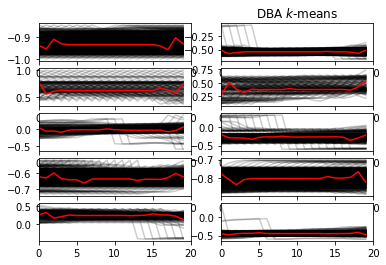

In [19]:
for yi in range(num_clusters):
    plt.subplot(5, 2, 1 + yi)
    for xx in x_train[y_pred == yi]:
        plt.plot(xx.flatten(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    if yi == 1:
        plt.title("DBA $k$-means")

In [20]:
mean = []
std = []
var = []


for i in range(num_clusters):

    cluster = x_train[y_pred == i]
    cluster = np.array(cluster)
    
    mean.append(np.mean(cluster))
    std.append(np.std(cluster))
    var.append(np.var(cluster, dtype=np.float64))
    

stats = pd.DataFrame({'mean': mean,
                    'standard deviation': std,
                    'variance': var

})

clusters = [i for i in range(num_clusters)]

stats.insert(0, 'clusters', clusters)
stats.set_index('clusters', inplace=True)


In [21]:
mean = []
std = []
var = []


for i in range(num_clusters):

    cluster = dba_km.cluster_centers_[i]

    mean.append(np.mean(cluster))
    std.append(np.std(cluster))
    var.append(np.var(cluster, dtype=np.float64))
    

stats_centroid = pd.DataFrame({'centroid mean': mean,
                    'centroid standard deviation': std,
                    'centroid variance': var

})

clusters = [i for i in range(num_clusters)]

stats_centroid.insert(0, 'clusters', clusters)
stats_centroid.set_index('clusters', inplace=True)


In [22]:
stats_centroid

,centroid mean,centroid standard deviation,centroid variance
clusters,,,
0,-0.934042,0.011152,0.000124
1,-0.542655,0.013617,0.000185
2,0.635241,0.048579,0.002360
3,0.382997,0.054632,0.002985
4,-0.018548,0.035493,0.001260
5,-0.275371,0.033262,0.001106
6,-0.633407,0.013492,0.000182
7,-0.799642,0.013454,0.000181
8,0.233279,0.039183,0.001535


In [23]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [24]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.02 MAPE
R-squared value is 0.991251074090343
RMSE:  47.586267776107164


In [25]:
torch.save(model, 'lstm_REL_clus.pt')

#### Predict the cluster for test data

In [26]:
res = dba_km.predict(x_test)

In [27]:
res

array([1, 1, 1, ..., 3, 3, 3])

In [28]:
np.where(res == 6)

(array([], dtype=int64),)

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'][-len(test_set):], mode='lines', name='closing price'))

#### Compute mean relative change for different test sequences

In [30]:
t = [150, 204, 264, 245, 180, 255, 195, 50, 284, 400]
mean = []
std = []
var = []
cluster_assigned = []
cluster_mean = []


for i in t:

    data = np.array(x_test[i])

    mean.append(np.mean(data))
    std.append(np.std(data))
    var.append(np.var(data, dtype=np.float64))
    cluster_assigned.append(res[i])

    cluster_mean.append(np.mean(dba_km.cluster_centers_[res[i]]))

tests = pd.DataFrame({'test values': t,
                    'mean': mean,
                    'standard deviation': std,
                    'variance': var,
                    'cluster_assigned': cluster_assigned,
                    'cluster_mean': cluster_mean

})
tests
    

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean
0,150,-0.477225,0.017106,0.000293,9,-0.446994
1,204,-0.314068,0.011268,0.000127,5,-0.275371
2,264,-0.393111,0.013314,0.000177,9,-0.446994
3,245,-0.395228,0.018598,0.000346,9,-0.446994
4,180,-0.342055,0.026747,0.000715,5,-0.275371
5,255,-0.387357,0.015592,0.000243,9,-0.446994
6,195,-0.303814,0.017983,0.000323,5,-0.275371
7,50,-0.517931,0.018744,0.000351,1,-0.542655
8,284,-0.372454,0.039074,0.001527,9,-0.446994
9,400,-0.290362,0.008052,0.000065,5,-0.275371


In [31]:
tests_mean = tests.copy()

In [32]:
tests_mean['mean diff'] = (tests_mean['mean'] - tests_mean['cluster_mean'])
tests_mean

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,mean diff
0,150,-0.477225,0.017106,0.000293,9,-0.446994,-0.030230
1,204,-0.314068,0.011268,0.000127,5,-0.275371,-0.038697
2,264,-0.393111,0.013314,0.000177,9,-0.446994,0.053883
3,245,-0.395228,0.018598,0.000346,9,-0.446994,0.051767
4,180,-0.342055,0.026747,0.000715,5,-0.275371,-0.066684
5,255,-0.387357,0.015592,0.000243,9,-0.446994,0.059638
6,195,-0.303814,0.017983,0.000323,5,-0.275371,-0.028442
7,50,-0.517931,0.018744,0.000351,1,-0.542655,0.024723
8,284,-0.372454,0.039074,0.001527,9,-0.446994,0.074540
9,400,-0.290362,0.008052,0.000065,5,-0.275371,-0.014991


In [33]:
tests_mean['mean relative change'] = tests_mean['mean diff'] / abs(tests_mean['cluster_mean'])
tests_mean

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,mean diff,mean relative change
0,150,-0.477225,0.017106,0.000293,9,-0.446994,-0.030230,-0.067630
1,204,-0.314068,0.011268,0.000127,5,-0.275371,-0.038697,-0.140526
2,264,-0.393111,0.013314,0.000177,9,-0.446994,0.053883,0.120546
3,245,-0.395228,0.018598,0.000346,9,-0.446994,0.051767,0.115811
4,180,-0.342055,0.026747,0.000715,5,-0.275371,-0.066684,-0.242160
5,255,-0.387357,0.015592,0.000243,9,-0.446994,0.059638,0.133419
6,195,-0.303814,0.017983,0.000323,5,-0.275371,-0.028442,-0.103287
7,50,-0.517931,0.018744,0.000351,1,-0.542655,0.024723,0.045560
8,284,-0.372454,0.039074,0.001527,9,-0.446994,0.074540,0.166759
9,400,-0.290362,0.008052,0.000065,5,-0.275371,-0.014991,-0.054440


(0.0, 20.0)

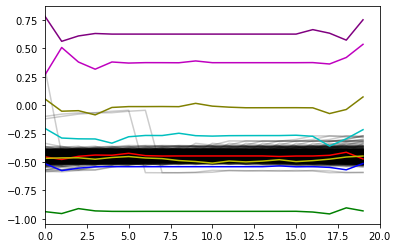

In [70]:
# plot x_test[150] 

for xx in x_train[y_pred == 9]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[9].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[2].ravel(), "purple")
plt.plot(x_test[150], "y-")
plt.xlim(0, sz)

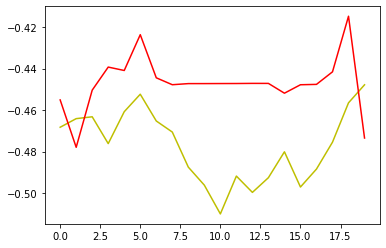

In [71]:
plt.plot(x_test[150], "y-")
plt.plot(dba_km.cluster_centers_[9].ravel(), "r-")
plt.show()

(0.0, 20.0)

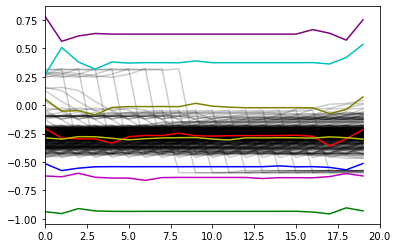

In [72]:
# plot x_test[400] 

for xx in x_train[y_pred == 5]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[5].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[6].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[3].ravel(), "c")
plt.plot(dba_km.cluster_centers_[2].ravel(), "purple")
plt.plot(x_test[400], "y-")
plt.xlim(0, sz)

#### Compute difference between maximum std of assigned cluster and various test sequences

In [37]:
tests_std_var = tests.copy()
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean
0,150,-0.477225,0.017106,0.000293,9,-0.446994
1,204,-0.314068,0.011268,0.000127,5,-0.275371
2,264,-0.393111,0.013314,0.000177,9,-0.446994
3,245,-0.395228,0.018598,0.000346,9,-0.446994
4,180,-0.342055,0.026747,0.000715,5,-0.275371
5,255,-0.387357,0.015592,0.000243,9,-0.446994
6,195,-0.303814,0.017983,0.000323,5,-0.275371
7,50,-0.517931,0.018744,0.000351,1,-0.542655
8,284,-0.372454,0.039074,0.001527,9,-0.446994
9,400,-0.290362,0.008052,0.000065,5,-0.275371


In [38]:
for clustercentre in tests_std_var['cluster_assigned']:
    print(type(clustercentre))
    print(clustercentre)
    break

<class 'int'>
9


In [39]:
cluster_std = []
cluster_var = []

for clustercentre in tests_std_var['cluster_assigned']:

    cluster = x_train[y_pred == clustercentre]
    cluster =  np.array(cluster)

    std = np.std(cluster, axis=1)
    var = np.var(cluster, axis=1)

    std = std.flatten()
    var = var.flatten()

    std_max_index = np.argmax(std)
    std_max = std.max()

    var_max_index = np.argmax(var)
    var_max = var.max()

    cluster_std.append(std_max)
    cluster_var.append(var_max)

In [40]:
tests_std_var = tests_std_var.assign(**{'cluster std': cluster_std, 'cluster variance':cluster_var})
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,cluster std,cluster variance
0,150,-0.477225,0.017106,0.000293,9,-0.446994,0.243050,0.059073
1,204,-0.314068,0.011268,0.000127,5,-0.275371,0.352370,0.124165
2,264,-0.393111,0.013314,0.000177,9,-0.446994,0.243050,0.059073
3,245,-0.395228,0.018598,0.000346,9,-0.446994,0.243050,0.059073
4,180,-0.342055,0.026747,0.000715,5,-0.275371,0.352370,0.124165
5,255,-0.387357,0.015592,0.000243,9,-0.446994,0.243050,0.059073
6,195,-0.303814,0.017983,0.000323,5,-0.275371,0.352370,0.124165
7,50,-0.517931,0.018744,0.000351,1,-0.542655,0.227126,0.051586
8,284,-0.372454,0.039074,0.001527,9,-0.446994,0.243050,0.059073
9,400,-0.290362,0.008052,0.000065,5,-0.275371,0.352370,0.124165


In [41]:
tests_std_var['max std diff'] = (tests_std_var['standard deviation'] - tests_std_var['cluster std'])
tests_std_var['std reltive change'] = tests_std_var['max std diff'] / abs(tests_std_var['cluster std'])
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,cluster std,cluster variance,max std diff,std reltive change
0,150,-0.477225,0.017106,0.000293,9,-0.446994,0.243050,0.059073,-0.225944,-0.929619
1,204,-0.314068,0.011268,0.000127,5,-0.275371,0.352370,0.124165,-0.341102,-0.968021
2,264,-0.393111,0.013314,0.000177,9,-0.446994,0.243050,0.059073,-0.229736,-0.945221
3,245,-0.395228,0.018598,0.000346,9,-0.446994,0.243050,0.059073,-0.224452,-0.923483
4,180,-0.342055,0.026747,0.000715,5,-0.275371,0.352370,0.124165,-0.325623,-0.924093
5,255,-0.387357,0.015592,0.000243,9,-0.446994,0.243050,0.059073,-0.227458,-0.935849
6,195,-0.303814,0.017983,0.000323,5,-0.275371,0.352370,0.124165,-0.334387,-0.948966
7,50,-0.517931,0.018744,0.000351,1,-0.542655,0.227126,0.051586,-0.208381,-0.917472
8,284,-0.372454,0.039074,0.001527,9,-0.446994,0.243050,0.059073,-0.203975,-0.839233
9,400,-0.290362,0.008052,0.000065,5,-0.275371,0.352370,0.124165,-0.344318,-0.977148


In [42]:
tests_std_var['max var diff'] = (tests_std_var['variance'] - tests_std_var['cluster variance'])
tests_std_var['var reltive change'] = tests_std_var['max var diff'] / abs(tests_std_var['cluster variance'])
tests_std_var

,test values,mean,standard deviation,variance,cluster_assigned,cluster_mean,cluster std,cluster variance,max std diff,std reltive change,max var diff,var reltive change
0,150,-0.477225,0.017106,0.000293,9,-0.446994,0.243050,0.059073,-0.225944,-0.929619,-0.058781,-0.995046
1,204,-0.314068,0.011268,0.000127,5,-0.275371,0.352370,0.124165,-0.341102,-0.968021,-0.124038,-0.998977
2,264,-0.393111,0.013314,0.000177,9,-0.446994,0.243050,0.059073,-0.229736,-0.945221,-0.058896,-0.996999
3,245,-0.395228,0.018598,0.000346,9,-0.446994,0.243050,0.059073,-0.224452,-0.923483,-0.058727,-0.994145
4,180,-0.342055,0.026747,0.000715,5,-0.275371,0.352370,0.124165,-0.325623,-0.924093,-0.123449,-0.994238
5,255,-0.387357,0.015592,0.000243,9,-0.446994,0.243050,0.059073,-0.227458,-0.935849,-0.058830,-0.995885
6,195,-0.303814,0.017983,0.000323,5,-0.275371,0.352370,0.124165,-0.334387,-0.948966,-0.123841,-0.997396
7,50,-0.517931,0.018744,0.000351,1,-0.542655,0.227126,0.051586,-0.208381,-0.917472,-0.051235,-0.993189
8,284,-0.372454,0.039074,0.001527,9,-0.446994,0.243050,0.059073,-0.203975,-0.839233,-0.057546,-0.974154
9,400,-0.290362,0.008052,0.000065,5,-0.275371,0.352370,0.124165,-0.344318,-0.977148,-0.124100,-0.999478


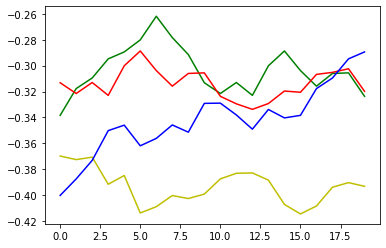

In [43]:
plt.plot(x_test[195], 'g')
plt.plot(x_test[204], 'r')
plt.plot(x_test[264], 'y')
plt.plot(x_test[180], 'b')

### Create a synthetic time sequence of 20 timesteps with high standard deviation (sudden jump)

In [44]:
t1 = np.arange(-1.0, -0.5, 0.05)
np.append(t1, 1)
len(t1)

10

In [45]:
t2 = np.arange(1.1, 1.6, 0.05)
len(t2)

10

In [46]:
final = np.concatenate((t1,t2))
final

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,
        1.5 ,  1.55])

In [47]:
len(final)

20

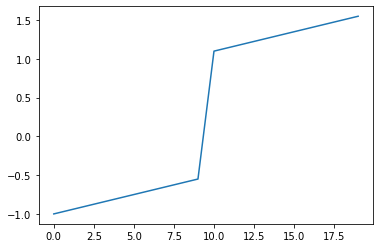

In [48]:
plt.plot(final)

In [49]:
np.std(final), np.mean(final), np.var(final)

(1.0597759197113323, 0.27500000000000024, 1.1231250000000002)

In [50]:
final = final.reshape(-1, 20, 1)

In [51]:
final_cluster = dba_km.predict(final)

In [52]:
final_cluster

array([3])

#### Compute the relative change in mean, std, var for this synthetic data point that has a sudden jump (therefore, high std).

In [53]:
mean_final = (np.mean(final) - tests_std_var['cluster_mean'][0]) / abs(tests_std_var['cluster_mean'][0])
std_final = ((np.std(final) - tests_std_var['cluster std'][0])) / abs(tests_std_var['cluster std'][0])
variance_final = ((np.var(final) - tests_std_var['cluster variance'][0])) / abs(tests_std_var['cluster variance'][0])

In [54]:
print("mean of synthetic time sequence:", mean_final)
print("std of synthetic time sequence:", std_final)
print("variance of synthetic time sequence:", variance_final)

mean of synthetic time sequence: 1.6152201718774581
std of synthetic time sequence: 3.360323637530348
variance of synthetic time sequence: 18.012421908910742


<ul>
    <li>The standard deviation is minimal as long as the signal is steady (with some noise). The standard deviation will increase if there is a jump in the signal.</li>
</ul>

### Create another time sequence with sudden fall in values

In [73]:
t2 = np.arange(1, 0.8, -0.025)
len(t2)

8

In [74]:
t2


array([1.   , 0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825])

In [75]:
t2 = np.append(t2, -0.8)

In [76]:
t1 = np.arange(-0.75, -0.64, 0.01)
len(t1)

11

In [77]:
t1

array([-0.75, -0.74, -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.67,
       -0.66, -0.65])

In [78]:
final_down = np.concatenate((t2, t1))
final_down

array([ 1.   ,  0.975,  0.95 ,  0.925,  0.9  ,  0.875,  0.85 ,  0.825,
       -0.8  , -0.75 , -0.74 , -0.73 , -0.72 , -0.71 , -0.7  , -0.69 ,
       -0.68 , -0.67 , -0.66 , -0.65 ])

In [79]:
len(final_down)

20

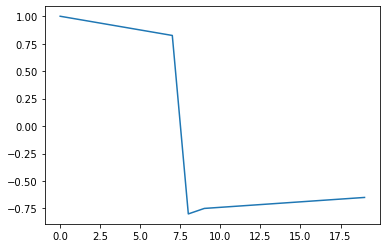

In [80]:
plt.plot(final_down)

In [81]:
final_down = final_down.reshape(-1, 20, 1)

In [82]:
final_down_cluster = dba_km.predict(final_down)
final_down_cluster

array([4])

In [83]:
cluster4_mean = np.mean(dba_km.cluster_centers_[4])
cluster4 = x_train[y_pred == 4]
cluster4 =  np.array(cluster4)

std = np.std(cluster4, axis=1)
var = np.var(cluster4, axis=1)

std = std.flatten()
var = var.flatten()

std_max_index = np.argmax(std)
std_max = std.max()

var_max_index = np.argmax(var)
var_max = var.max()


In [84]:
np.mean(final_down), cluster4_mean

(-0.06000000000000001, -0.018547626076327196)

In [85]:
mean_final_down = ((np.mean(final_down)) - cluster4_mean) / abs(cluster4_mean)
std_final_down = (np.std(final_down) - std_max) / abs(std_max)
variance_final_down = (np.var(final_down) - var_max) / abs(var_max)

In [86]:
print("mean of synthetic time sequence:", mean_final_down)
print("std of synthetic time sequence:", std_final_down)
print("variance of synthetic time sequence:", variance_final_down)

mean of synthetic time sequence: -2.2349153338054153
std of synthetic time sequence: 1.2555687397248947
variance of synthetic time sequence: 4.087590644011715
